In [21]:
library(dplyr)
library(tidyr)
library(ggsci)
library(readr)
library(lfe)
library(stringr)
library(fixest)
library(ggplot2)
library(doMC)
registerDoMC(20)

In [9]:
df <- data.table::fread('/pool001/mfzhao/PROCESSED_DATA/dyadic_mvmt_2020.csv')
pp <- read_csv('/pool001/mfzhao/PROCESSED_DATA/policyPeriods.csv')

Parsed with column specification:
cols(
  key = col_character(),
  p1sdp = col_date(format = ""),
  p2shp = col_date(format = ""),
  p3rop = col_date(format = "")
)



In [10]:
df %>% 
    filter(origin_cluster != destination_cluster) %>%
    mutate(oRain  = as.numeric(oPRCP > 0),
           dRain  = as.numeric(dPRCP > 0),
           nearby = as.numeric(dist < 100)) -> df

In [11]:
pp %>%
    mutate(cluster = as.numeric(str_sub(key, 1, 2))) %>%
    select(-key) %>%
    distinct() %>%
    rename(p1date = p1sdp, 
           p2date = p2shp,
           p3date = p3rop) -> statePolicy

In [12]:
cns     <- colnames(df)
wctrls  <- str_c(cns[str_detect(cns, '[od][pt][rm][ca][px]..')], collapse = ' + ')
cdctrls <- str_c(cns[str_detect(cns, '[od][acs][st]_')], collapse = ' + ')
ctrls   <- str_c(wctrls, ' + ', cdctrls)

In [18]:
fri <- function(df) {
    statePolicy %>%
        mutate(cluster = sample(cluster, n(), replace = F)) -> swap
    
    df %>%
        select(-matches('[od]p[123]')) %>%
        left_join(swap %>%
                  rename(origin_cluster = cluster,
                         odate1 = p1date,
                         odate2 = p2date,
                         odate3 = p3date)) %>%
        left_join(swap %>%
                  rename(destination_cluster = cluster,
                         ddate1 = p1date,
                         ddate2 = p2date,
                         ddate3 = p3date)) %>%
        mutate(op1 = as.numeric(difftime(date, odate1, units = 'day') >= 0),
               op2 = as.numeric(difftime(date, odate2, units = 'day') >= 0),
               op3 = as.numeric(difftime(date, odate3, units = 'day') >= 0),
               dp1 = as.numeric(difftime(date, ddate1, units = 'day') >= 0),
               dp2 = as.numeric(difftime(date, ddate2, units = 'day') >= 0),
               dp3 = as.numeric(difftime(date, ddate3, units = 'day') >= 0)) %>%
        replace_na(list(op2 = 0, dp2 = 0)) %>%
        select(-matches('[od]date')) -> temp
    
    f1 <- str_c('log(ndotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, 
                ' | dyad + date | 0 | origin_cluster + destination_cluster')
    f2 <- str_c('log(pdotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, 
                ' | dyad + date | 0 | origin_cluster + destination_cluster')
    
    fit1 <- felm(as.formula(f1), temp)
    fit2 <- felm(as.formula(f2), temp, weights = temp$n)
    
    as.data.frame(summary(fit1)$coef) %>%
        mutate(var  = rownames(.),
               dv   = 'ndotd') %>%
        bind_rows(as.data.frame(summary(fit2)$coef) %>% 
                  mutate(var  = rownames(.),
                         dv   = 'pdotd')) %>%
        rename(estimate = Estimate, se = `Cluster s.e.`) %>%
        filter(str_detect(var, '[od]p[123]')) -> out
    
    write_csv(out, str_c('~/progress/', str_pad(i, 3, pad = '0'), '.csv'))
    return(out)
}

ts <- Sys.time()
foreach(i = 1:10, .combine = rbind) %do% fri(df) -> fri_results
te <- Sys.time()

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Warning message in newols(mm, nostats = nostats[1], exactDOF = exactDOF, onlyse = onlyse, :
“Negative eigenvalues set to zero in multiway clustered variance matrix. See felm(...,psdef=FALSE)”
Warning message in newols(mm, nostats = nostats[1], exactDOF = exactDOF, onlyse = onlyse, :
“Negative eigenvalues set to zero in multiway clustered variance matrix. See felm(...,psdef=FALSE)”
Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”
Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”
Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Warning message in newols(mm, nostats = nostats[1], exactDOF = exactDOF, onlyse = onlyse, :
“Negative eigenvalues set to zero in multiway clustered variance matrix. See felm(...,psdef=FALSE)”
Warning message in newols(mm, nostats = nostats[1], exac

In [32]:
fri <- function(df, i) {
    statePolicy %>%
        mutate(cluster = sample(cluster, n(), replace = F)) -> swap
    
    df %>%
        select(-matches('[od]p[123]')) %>%
        left_join(swap %>%
                  rename(origin_cluster = cluster,
                         odate1 = p1date,
                         odate2 = p2date,
                         odate3 = p3date)) %>%
        left_join(swap %>%
                  rename(destination_cluster = cluster,
                         ddate1 = p1date,
                         ddate2 = p2date,
                         ddate3 = p3date)) %>%
        mutate(op1 = as.numeric(difftime(date, odate1, units = 'day') >= 0),
               op2 = as.numeric(difftime(date, odate2, units = 'day') >= 0),
               op3 = as.numeric(difftime(date, odate3, units = 'day') >= 0),
               dp1 = as.numeric(difftime(date, ddate1, units = 'day') >= 0),
               dp2 = as.numeric(difftime(date, ddate2, units = 'day') >= 0),
               dp3 = as.numeric(difftime(date, ddate3, units = 'day') >= 0)) %>%
        replace_na(list(op2 = 0, dp2 = 0)) %>%
        select(-matches('[od]date')) -> temp
    
    f1 <- str_c('log(ndotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, 
                ' | dyad + date ')
    f2 <- str_c('log(pdotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, 
                ' | dyad + date ')
    
    fit1 <- feols(as.formula(f1), temp, nthreads = 20)
    fit2 <- feols(as.formula(f2), temp, weights = temp$n, nthreads = 20)
    
    summary(fit1)$coeftable %>%
        mutate(var  = rownames(.),
               dv   = 'ndotd') %>%
        bind_rows(summary(fit2)$coeftable %>% 
                  mutate(var  = rownames(.),
                         dv   = 'pdotd')) %>%
        rename(estimate = Estimate) %>%
        filter(str_detect(var, '[od]p[123]')) -> out
    
    write_csv(out, str_c('~/progress/', str_pad(i, 3, pad = '0'), '.csv'))
    return(out)
}

ts <- Sys.time()
foreach(i = 1:500, .combine = rbind) %do% fri(df, i) -> fri_results
te <- Sys.time()

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Jo

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Jo

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Jo

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Jo

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Joining, by = "destination_cluster"

Joining, by = "origin_cluster"

Jo

In [36]:
f1 <- str_c('log(ndotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, 
            ' | dyad + date | 0 | origin_cluster + destination_cluster')
f2 <- str_c('log(pdotd) ~ op1 + op2 + op3 + dp1 + dp2 + dp3 + ', ctrls, 
            ' | dyad + date | 0 | origin_cluster + destination_cluster')

fit1 <- felm(as.formula(f1), df)
fit2 <- felm(as.formula(f2), df, weights = df$n)

as.data.frame(summary(fit1)$coef) %>%
    mutate(var  = rownames(.),
            dv   = 'ndotd') %>%
    bind_rows(as.data.frame(summary(fit2)$coef) %>% 
              mutate(var  = rownames(.),
                     dv   = 'pdotd')) %>%
    rename(estimate = Estimate, se = `Cluster s.e.`) %>%
    filter(str_detect(var, '[od]p[123]')) -> base

Warning message in newols(mm, nostats = nostats[1], exactDOF = exactDOF, onlyse = onlyse, :
“Negative eigenvalues set to zero in multiway clustered variance matrix. See felm(...,psdef=FALSE)”
Warning message in newols(mm, nostats = nostats[1], exactDOF = exactDOF, onlyse = onlyse, :
“Negative eigenvalues set to zero in multiway clustered variance matrix. See felm(...,psdef=FALSE)”
Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”
Warning message in chol.default(mat, pivot = TRUE, tol = tol):
“the matrix is either rank-deficient or indefinite”


Time difference of -1.075715 mins

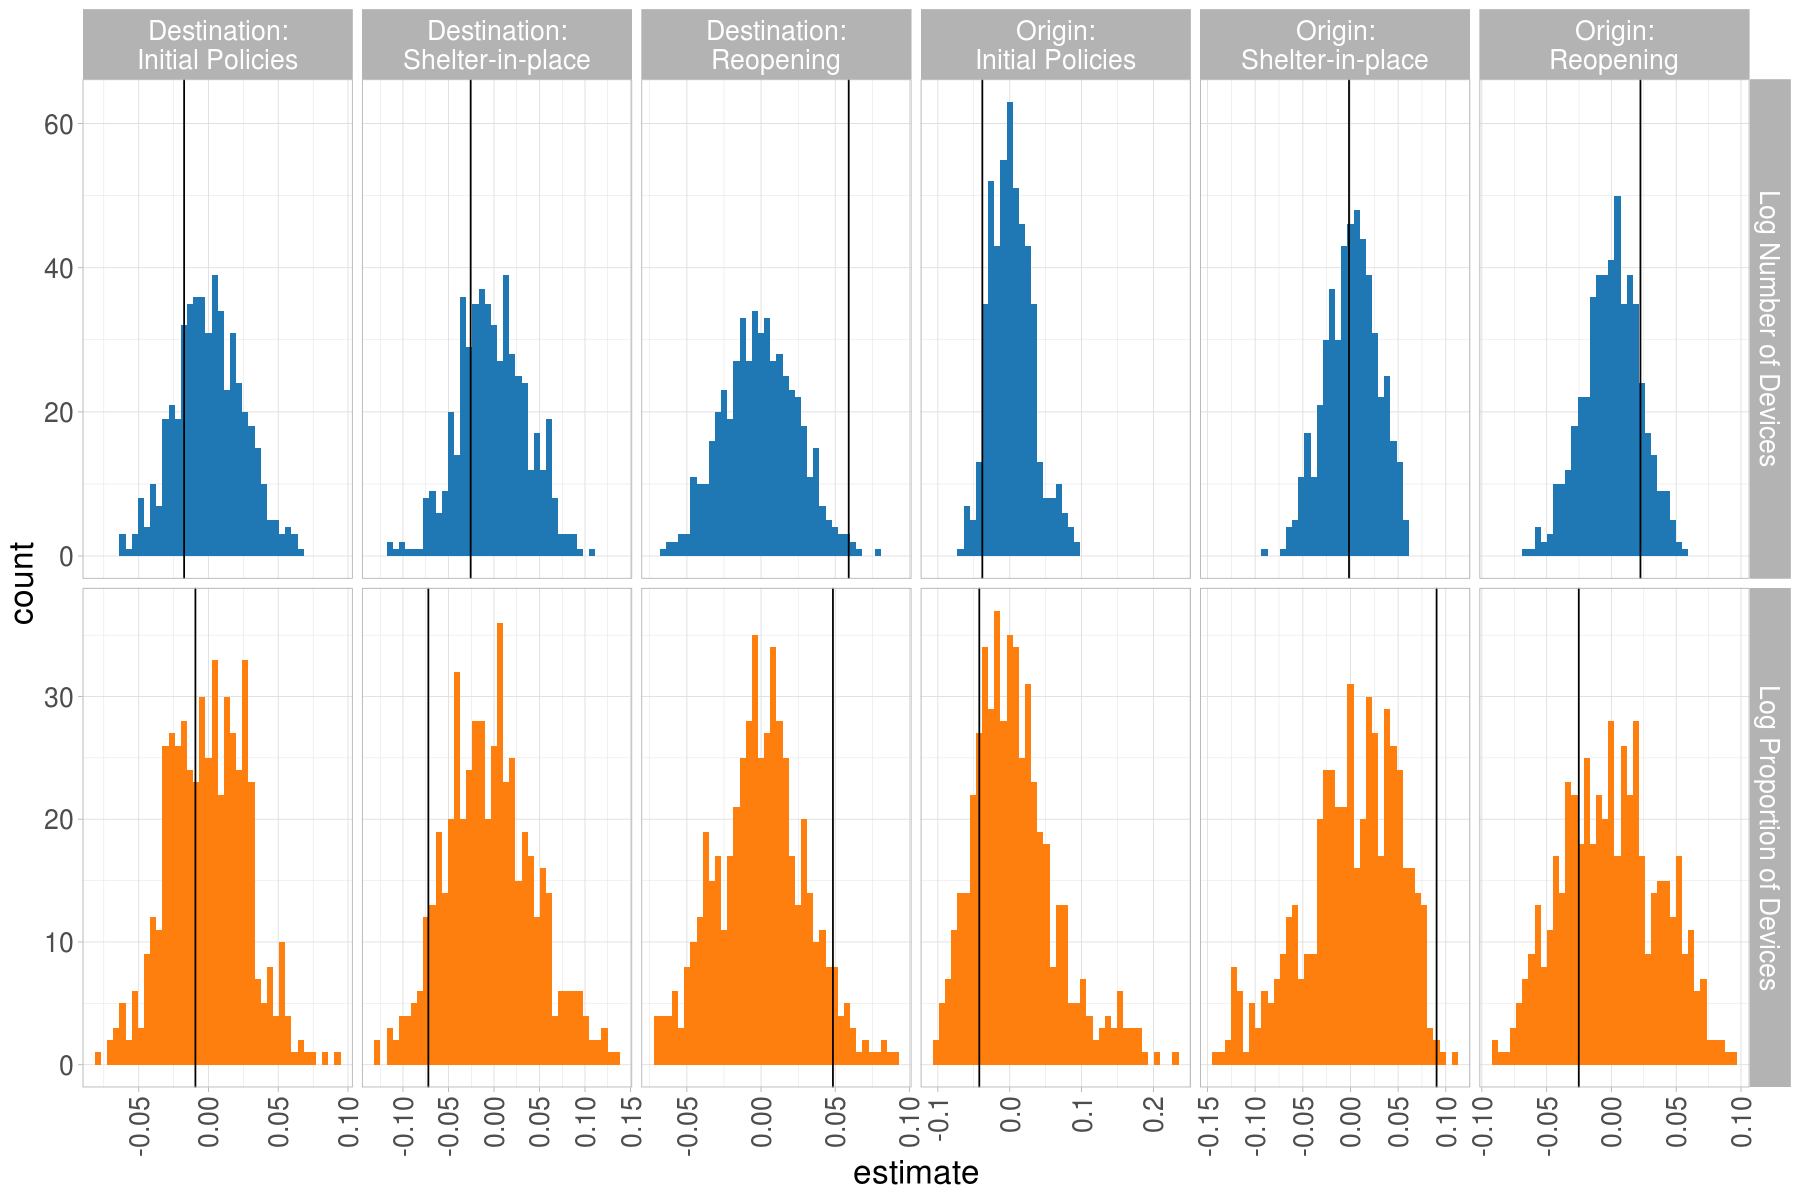

In [50]:
vns <- c('dp1'   = "Destination:\nInitial Policies",
         'dp2'   = "Destination:\nShelter-in-place",
         'dp3'   = "Destination:\nReopening",
         'op1'   = 'Origin:\nInitial Policies',
         'op2'   = 'Origin:\nShelter-in-place',
         'op3'   = 'Origin:\nReopening',
         'pdotd' = 'Log Proportion of Devices', 
         'ndotd' = 'Log Number of Devices')

options(repr.plot.width=15, repr.plot.height=10)
fri_results %>%
    ggplot(aes(x = estimate, fill = dv)) +
    geom_histogram(bins = 40) +
    geom_vline(aes(xintercept = estimate), data = base) +
    facet_grid(dv ~ var, scales = 'free', labeller = as_labeller(vns)) +
    theme_light() +
    scale_fill_d3() +
    theme(text = element_text(size = 20),
          axis.text.x = element_text(angle = 90, hjust = 1, vjust = 0.5),
          legend.position = 'None') -> p

p
ggsave('/home/mfzhao/SI_plots/rc3b_fri_dyad.pdf', p, device = 'pdf', width = 6.5, height = 6.5, scale = 2)